# Numerically fit and remove the goethite component in RT-SIRM curves

This notebook applies an approach of fitting and then subtracting a polynomial to Room Temperature Saturation Isothermal Remanent Magnetization (RT-SIRM) low-temperature cycling data in order to approximately remove the contribution that could be due to goethite. The goal in doing so is to be able to isolate the change in remanence that could be associated with other behavior such as the Verwey and Morin transitions.

## Introduction to goethite and its low-temperature behavior

Goethite (α-FeOOH) is a common oxyhydroxide within soils, sediments, and other oxidized materials on Earth's surface. When goethite is cooled from room temperature (~300 K) to lower temperatures, it exhibits an increase in its magnetization ([Rochette and Fillion, 1989](http://doi.org/10.1029/GL016i008p00851)). This increase is reversible when goethite is warmed back up to room temperature ([Carter-Stiglitz et al., 2006](http://doi.org/10.1016/j.palaeo.2006.01.008)). 

As a result of this low-temperature behavior, goethite exhibits an increasing slope in experiments on an MPMS where a sample is pulsed with a field at room temperature and then cooled in zero field to low-temperature. Such an experiment is known as an RT-SIRM low-temperature cycling experiment and is denoted with the MagIC method codes:
- `LP-CW-SIRM:LP-MC` (Cycling between cooling and warming: Room temperature SIRM; Measured while cooling)
- `LP-CW-SIRM:LP-MW` (Cycling between cooling and warming: Room temperature SIRM; Measured while warming)

In a sample of mixed mineralogy that contains goethite, this low-temperature behavior is useful for inferring the presence of goethite. Such an interpretation can be further strengthened by data from zero-field cooled (ZFC) and field cooled (FC) remanence upon warming experiments. Such experiments both show a progressive loss of remanence upon warming that typically is continuous from the lowest temperature of the experiment (typically 10 K) to the highest temperature of the experiement (typically 300 K). Additionally, a diagnostic behavior for goethite is that the FC curve has a stronger magnetization than the ZFC curve ([Liu et al., 2006](https://doi.org/10.1029/2006JB004560)). Τhe reason for the loss in remanent magnetization upon warming in these FC/ZFC experiments, as well as the difference in the FC and ZFC magnetization, is that some of the goethite grains are acquiring a thermal remanent magnetization with more of a thermal remanence being blocked during the FC experiment ([Liu et al., 2006](https://doi.org/10.1029/2006JB004560)). Samples showing this behavior are indicative of blocking temperatures below 300 K ([Liu et al., 2006](https://doi.org/10.1029/2006JB004560)).

In summary:

> "The combination of the large discrepancy between the FC and ZFC curves, and the large and reversible increase in remanence upon cooling, are therefore diagnostic of the presence of goethite" ([Liu et al., 2006](https://doi.org/10.1029/2006JB004560)).


## Removing the goethite component

While this low-temperature behavior is quite useful for diagnosing the presence of goethite, it can be a nuisance in the results of such experiments as it can obscure the behavior of other phases. There are two main approaches for dealing with this issue and removing the contribution of goethite:
- **experimentally**: given the low N&eacute;el temperature of goethite of ~120 º (corresponding to 393 K), an experimental protocol that is utilized is to heat a specimen to 400 K in order to demagnetize magnetization associated with goethite prior to cooling to low temperature. Such a step is incorporated in the "goethite" test where the difference between magnetization with and without this 400 K heating step is used to quantify goethite abundance ([Guyodo et al., 2006](http://doi.org/10.1016/j.epsl.2006.09.005)). See discussion of this test in [Bilardello, 2009](https://drive.google.com/file/d/1f425KX5fsiNeswUnGQbpYov1hTfQA4ib/view?usp=sharing).
- **numerically**: the approach taken in this notebook is to apply a polynomial fit to the warming portion of the RTSIRM low-temperature cycling curve and to then subtract that fit from the cooling and warming curve. This approach has been taken in the literature such as in [Silveira et al., 2021](https://doi.org/10.2110/jsr.2020.089). This approach models the goethite contribution with a polynomial fit (typically a second order polynomial) and then substracts that from the curve. The goal is to enable features of the data to emerge and be quantified that would otherwise be obscured.

## Import Python packages

In [1]:
import rockmag as rmag
import pmagpy.ipmag as ipmag
import pmagpy.contribution_builder as cb

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Import data

In [3]:
# set the directory path (dir_path) to the data
dir_path = './example_data/goethite'

ipmag.download_magic('A73-7-1350-4B-01a_mpms.txt', 
                     dir_path = dir_path,
                     input_dir_path = dir_path)

# create a contribution object from the tables in the directory
contribution = cb.Contribution(dir_path)
measurements = contribution.tables['measurements'].df

measurements.dropna(axis=1, how='all').head() # see the first 5 measurements without empty columns

working on:  'specimens\r'
1  records written to file  /Users/penokean/0000_GitHub/RockmagPy-notebooks/example_data/goethite/specimens.txt
  data put in  /Users/penokean/0000_GitHub/RockmagPy-notebooks/example_data/goethite/specimens.txt
working on:  'samples\r'
1  records written to file  /Users/penokean/0000_GitHub/RockmagPy-notebooks/example_data/goethite/samples.txt
  data put in  /Users/penokean/0000_GitHub/RockmagPy-notebooks/example_data/goethite/samples.txt
working on:  'sites\r'
1  records written to file  /Users/penokean/0000_GitHub/RockmagPy-notebooks/example_data/goethite/sites.txt
  data put in  /Users/penokean/0000_GitHub/RockmagPy-notebooks/example_data/goethite/sites.txt
working on:  'locations\r'
1  records written to file  /Users/penokean/0000_GitHub/RockmagPy-notebooks/example_data/goethite/locations.txt
  data put in  /Users/penokean/0000_GitHub/RockmagPy-notebooks/example_data/goethite/locations.txt
working on:  'measurements\r'
240  records written to file  /Users

,experiment,instrument_codes,magn_mass,magn_r2_det,meas_field_dc,meas_temp,measurement,method_codes,quality,specimen,standard,timestamp
measurement name,,,,,,,,,,,,
A73-7-1350-4B-01a-LP-FC-DC-14109-0-0,A73-7-1350-4B-01a-LP-FC-DC-14109,IRM-MPMS3,0.027394,2.715563e-07,0.002531,10.000116,A73-7-1350-4B-01a-LP-FC-DC-14109-0-0,LP-FC,g,A73-7-1350-4B-01a,u,2093:06:23:05:14:35.739
A73-7-1350-4B-01a-LP-FC-DC-14109-0-1,A73-7-1350-4B-01a-LP-FC-DC-14109,IRM-MPMS3,0.027376,2.660482e-07,0.002531,10.265534,A73-7-1350-4B-01a-LP-FC-DC-14109-0-1,LP-FC,g,A73-7-1350-4B-01a,u,2093:06:23:05:14:39.928
A73-7-1350-4B-01a-LP-FC-DC-14109-0-2,A73-7-1350-4B-01a-LP-FC-DC-14109,IRM-MPMS3,0.024952,1.203919e-06,0.002531,15.057111,A73-7-1350-4B-01a-LP-FC-DC-14109-0-2,LP-FC,g,A73-7-1350-4B-01a,u,2093:06:23:05:15:12.16
A73-7-1350-4B-01a-LP-FC-DC-14109-0-3,A73-7-1350-4B-01a-LP-FC-DC-14109,IRM-MPMS3,0.022089,8.515676e-07,0.002531,20.002497,A73-7-1350-4B-01a-LP-FC-DC-14109-0-3,LP-FC,g,A73-7-1350-4B-01a,u,2093:06:23:05:15:42.989
A73-7-1350-4B-01a-LP-FC-DC-14109-0-4,A73-7-1350-4B-01a-LP-FC-DC-14109,IRM-MPMS3,0.020069,6.714368e-07,0.002531,25.103758,A73-7-1350-4B-01a-LP-FC-DC-14109-0-4,LP-FC,g,A73-7-1350-4B-01a,u,2093:06:23:05:16:16.287


## Summarize experiments

In [4]:
experiments = measurements.groupby(['specimen', 'method_codes']).size().reset_index().iloc[:, :2]
experiments

,specimen,method_codes
0,A73-7-1350-4B-01a,LP-CW-SIRM:LP-MC
1,A73-7-1350-4B-01a,LP-CW-SIRM:LP-MW
2,A73-7-1350-4B-01a,LP-FC
3,A73-7-1350-4B-01a,LP-ZFC


## Plot data

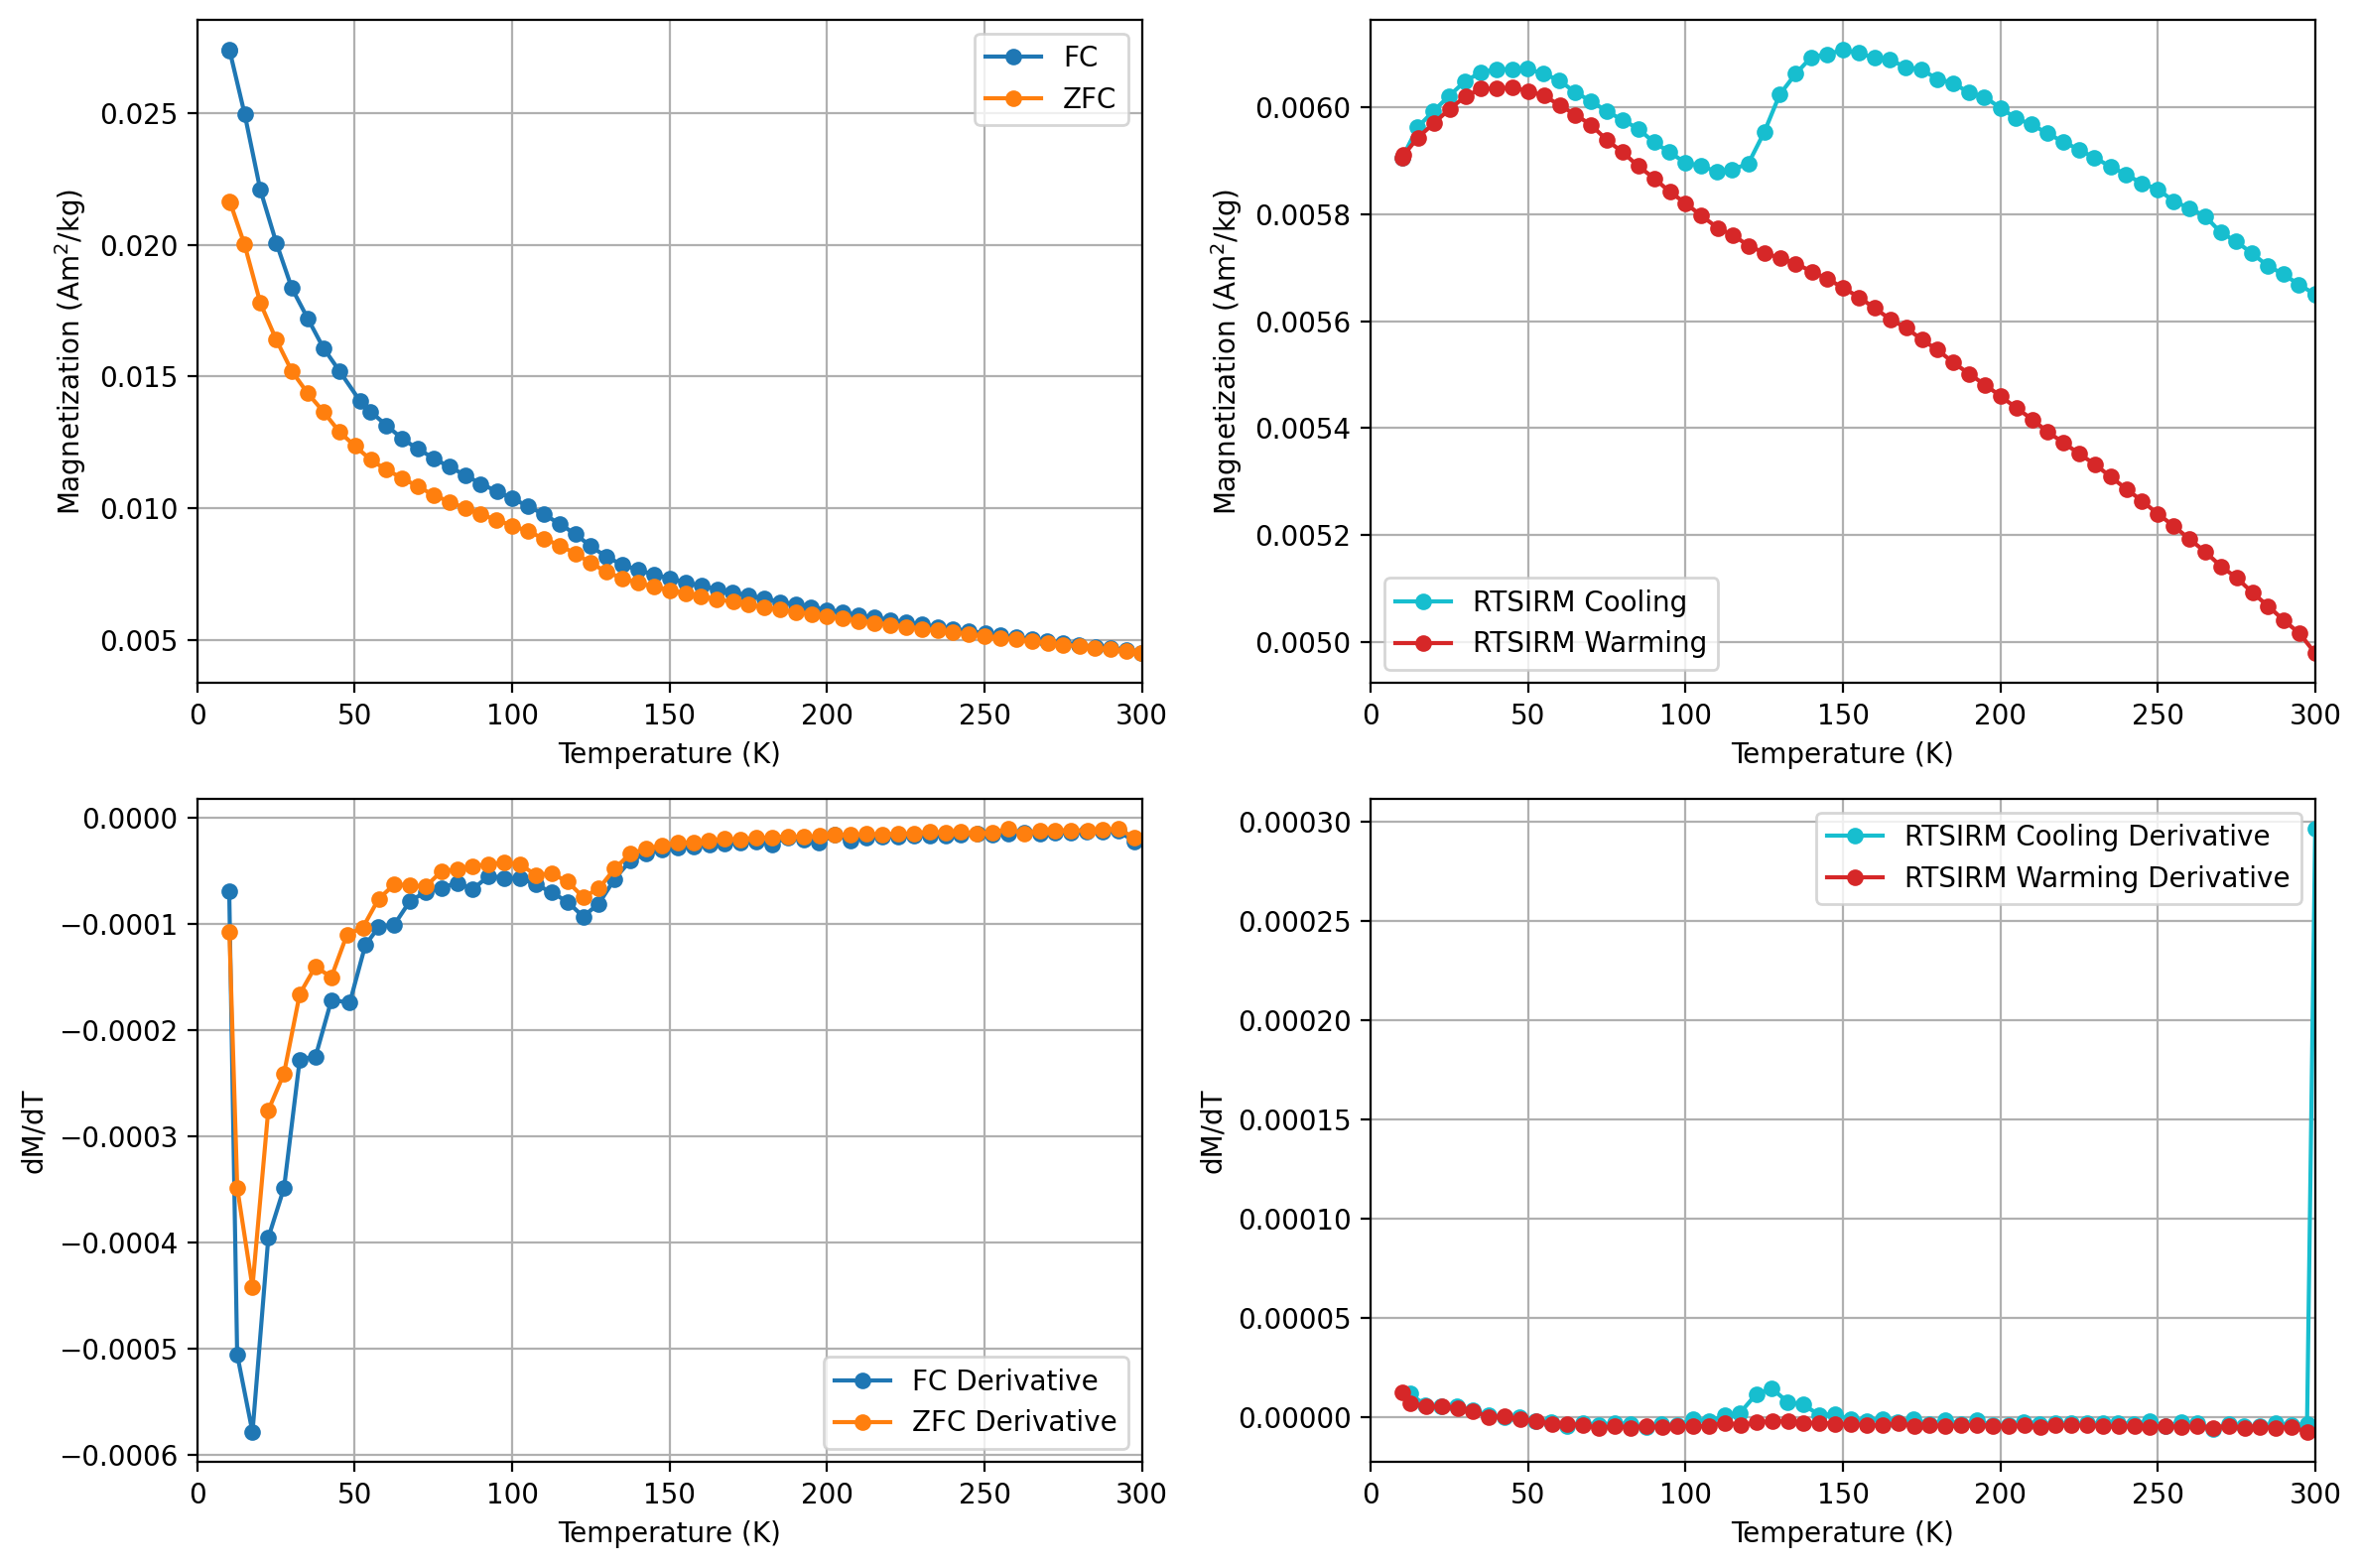

In [5]:
specimen_name = 'A73-7-1350-4B-01a'
fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data = rmag.extract_mpms_data(measurements, specimen_name)
rmag.plot_mpms_data(fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data,
                    plot_derivative=True)

## Define a function to numerically remove goethite

In the code cell below, a function is defined that fits the slope of the RTSIRM warming curve to approximately remove the contribution of the curve that is due to goethite. The uncorrected and corrected data as well as their derivatives are plotted. The function using both `numpy` functions and the `rmag.thermomag_derivative` function.

In [12]:
def goethite_removal(rtsirm_warm_data, 
                     rtsirm_cool_data,
                     t_min=150, t_max=290, poly_deg=2,
                     rtsirm_cool_color='#17becf', rtsirm_warm_color='#d62728',
                     symbol_size=4, return_data=False):
    """
    Analyzes and visualizes the removal of goethite signal from Room Temperature Saturation
    Isothermal Remanent Magnetization (RTSIRM) warming and cooling data. The function fits
    a polynomial to the RTSRIM warming curve between specified temperature bounds to model
    the goethite contribution, then subtracts this fit from the original data. The corrected
    and uncorrected magnetizations are plotted, along with their derivatives, to assess the
    effect of goethite removal.

    Parameters:
        rtsirm_warm_data (pd.DataFrame): DataFrame containing 'meas_temp' and 'magn_mass' columns
                                         for RTSIRM warming data.
        rtsirm_cool_data (pd.DataFrame): DataFrame containing 'meas_temp' and 'magn_mass' columns
                                         for RTSIRM cooling data.
        t_min (int, optional): Minimum temperature for polynomial fitting. Default is 150.
        t_max (int, optional): Maximum temperature for polynomial fitting. Default is 290.
        poly_deg (int, optional): Degree of the polynomial to fit. Default is 2.
        rtsirm_cool_color (str, optional): Color code for plotting cooling data. Default is '#17becf'.
        rtsirm_warm_color (str, optional): Color code for plotting warming data. Default is '#d62728'.
        symbol_size (int, optional): Size of the markers in the plots. Default is 4.
        return_data (bool, optional): If True, returns the corrected magnetization data for both
                                      warming and cooling. Default is False.

    Returns:
        Tuple[pd.Series, pd.Series]: Only if return_data is True. Returns two pandas Series
                                     containing the corrected magnetization data for the warming
                                     and cooling sequences, respectively.
    """
    
    rtsirm_warm_temps = rtsirm_warm_data['meas_temp']
    rtsirm_warm_mags = rtsirm_warm_data['magn_mass']
    rtsirm_cool_temps = rtsirm_cool_data['meas_temp']
    rtsirm_cool_mags = rtsirm_cool_data['magn_mass']
    
    rtsirm_warm_temps.reset_index(drop=True, inplace=True)
    rtsirm_warm_mags.reset_index(drop=True, inplace=True)
    
    rtsirm_warm_temps_filtered_indices = [i for i in np.arange(len(rtsirm_warm_temps)) if ((float(rtsirm_warm_temps[i]) > float(t_min)) and (float(rtsirm_warm_temps[i])  < float(t_max)) )]
    rtsirm_warm_temps_filtered = rtsirm_warm_temps[rtsirm_warm_temps_filtered_indices]
    rtsirm_warm_mags_filtered = rtsirm_warm_mags[rtsirm_warm_temps_filtered_indices]
    
    geothite_fit = np.polyfit(rtsirm_warm_temps_filtered, rtsirm_warm_mags_filtered, poly_deg)
    rtsirm_warm_mags_polyfit = np.poly1d(geothite_fit)(rtsirm_warm_temps)
    rtsirm_cool_mags_polyfit = np.poly1d(geothite_fit)(rtsirm_cool_temps)
    
    rtsirm_warm_mags_corrected = rtsirm_warm_mags - rtsirm_warm_mags_polyfit
    rtsirm_cool_mags_corrected = rtsirm_cool_mags - rtsirm_cool_mags_polyfit
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    
    axs[0, 0].plot(rtsirm_warm_temps, rtsirm_warm_mags, color=rtsirm_warm_color, 
                   marker='o', linestyle='-', markersize=symbol_size, label='RTSIRM Warming')
    axs[0, 0].plot(rtsirm_cool_temps, rtsirm_cool_mags, color=rtsirm_cool_color, 
                   marker='o', linestyle='-', markersize=symbol_size, label='RTSIRM Cooling')
    axs[0, 1].plot(rtsirm_warm_temps, rtsirm_warm_mags_corrected, color=rtsirm_warm_color, 
                   marker='s', linestyle='-', markersize=symbol_size, label='RTSIRM Warming (goethite removed)')
    axs[0, 1].plot(rtsirm_cool_temps, rtsirm_cool_mags_corrected, color=rtsirm_cool_color, 
                   marker='s', linestyle='-', markersize=symbol_size, label='RTSIRM Cooling (goethite removed)')
    for ax in axs[0, :]:
        ax.set_xlabel("Temperature (K)")
        ax.set_ylabel("Magnetization (Am$^2$/kg)")
        ax.legend()
        ax.grid(True)
        ax.set_xlim(0, 300)
        
        
    rtsirm_cool_derivative = rmag.thermomag_derivative(rtsirm_cool_data['meas_temp'], 
                                                       rtsirm_cool_data['magn_mass'], drop_first=True)
    rtsirm_warm_derivative = rmag.thermomag_derivative(rtsirm_warm_data['meas_temp'], 
                                                       rtsirm_warm_data['magn_mass'], drop_last=True)
    
    rtsirm_cool_derivative_corrected = rmag.thermomag_derivative(rtsirm_cool_data['meas_temp'], 
                                                       rtsirm_cool_mags_corrected, drop_first=True)
    rtsirm_warm_derivative_corrected = rmag.thermomag_derivative(rtsirm_warm_data['meas_temp'], 
                                                       rtsirm_warm_mags_corrected, drop_last=True)


    axs[1, 0].plot(rtsirm_cool_derivative['T'], rtsirm_cool_derivative['dM_dT'], 
                   marker='o', linestyle='-', color=rtsirm_cool_color, markersize=symbol_size, label='RTSIRM Cooling Derivative')
    axs[1, 0].plot(rtsirm_warm_derivative['T'], rtsirm_warm_derivative['dM_dT'], 
                   marker='o', linestyle='-', color=rtsirm_warm_color, markersize=symbol_size, label='RTSIRM Warming Derivative')        
    axs[1, 1].plot(rtsirm_cool_derivative_corrected['T'], rtsirm_cool_derivative_corrected['dM_dT'], 
                   marker='s', linestyle='-', color=rtsirm_cool_color, markersize=symbol_size, label='RTSIRM Cooling Derivative\n(goethite removed)')
    axs[1, 1].plot(rtsirm_warm_derivative_corrected['T'], rtsirm_warm_derivative_corrected['dM_dT'], 
                   marker='s', linestyle='-', color=rtsirm_warm_color, markersize=symbol_size, label='RTSIRM Warming Derivative\n(goethite removed)')  
    for ax in axs[1, :]:
        ax.set_xlabel("Temperature (K)")
        ax.set_ylabel("dM/dT")
        ax.legend()
        ax.grid(True)
        ax.set_xlim(0, 300)

    fig.tight_layout()
    plt.show()

    if return_data:
        return rtsirm_warm_mags_corrected, rtsirm_cool_mags_corrected

## Apply the function

The function can now be applied to the data.

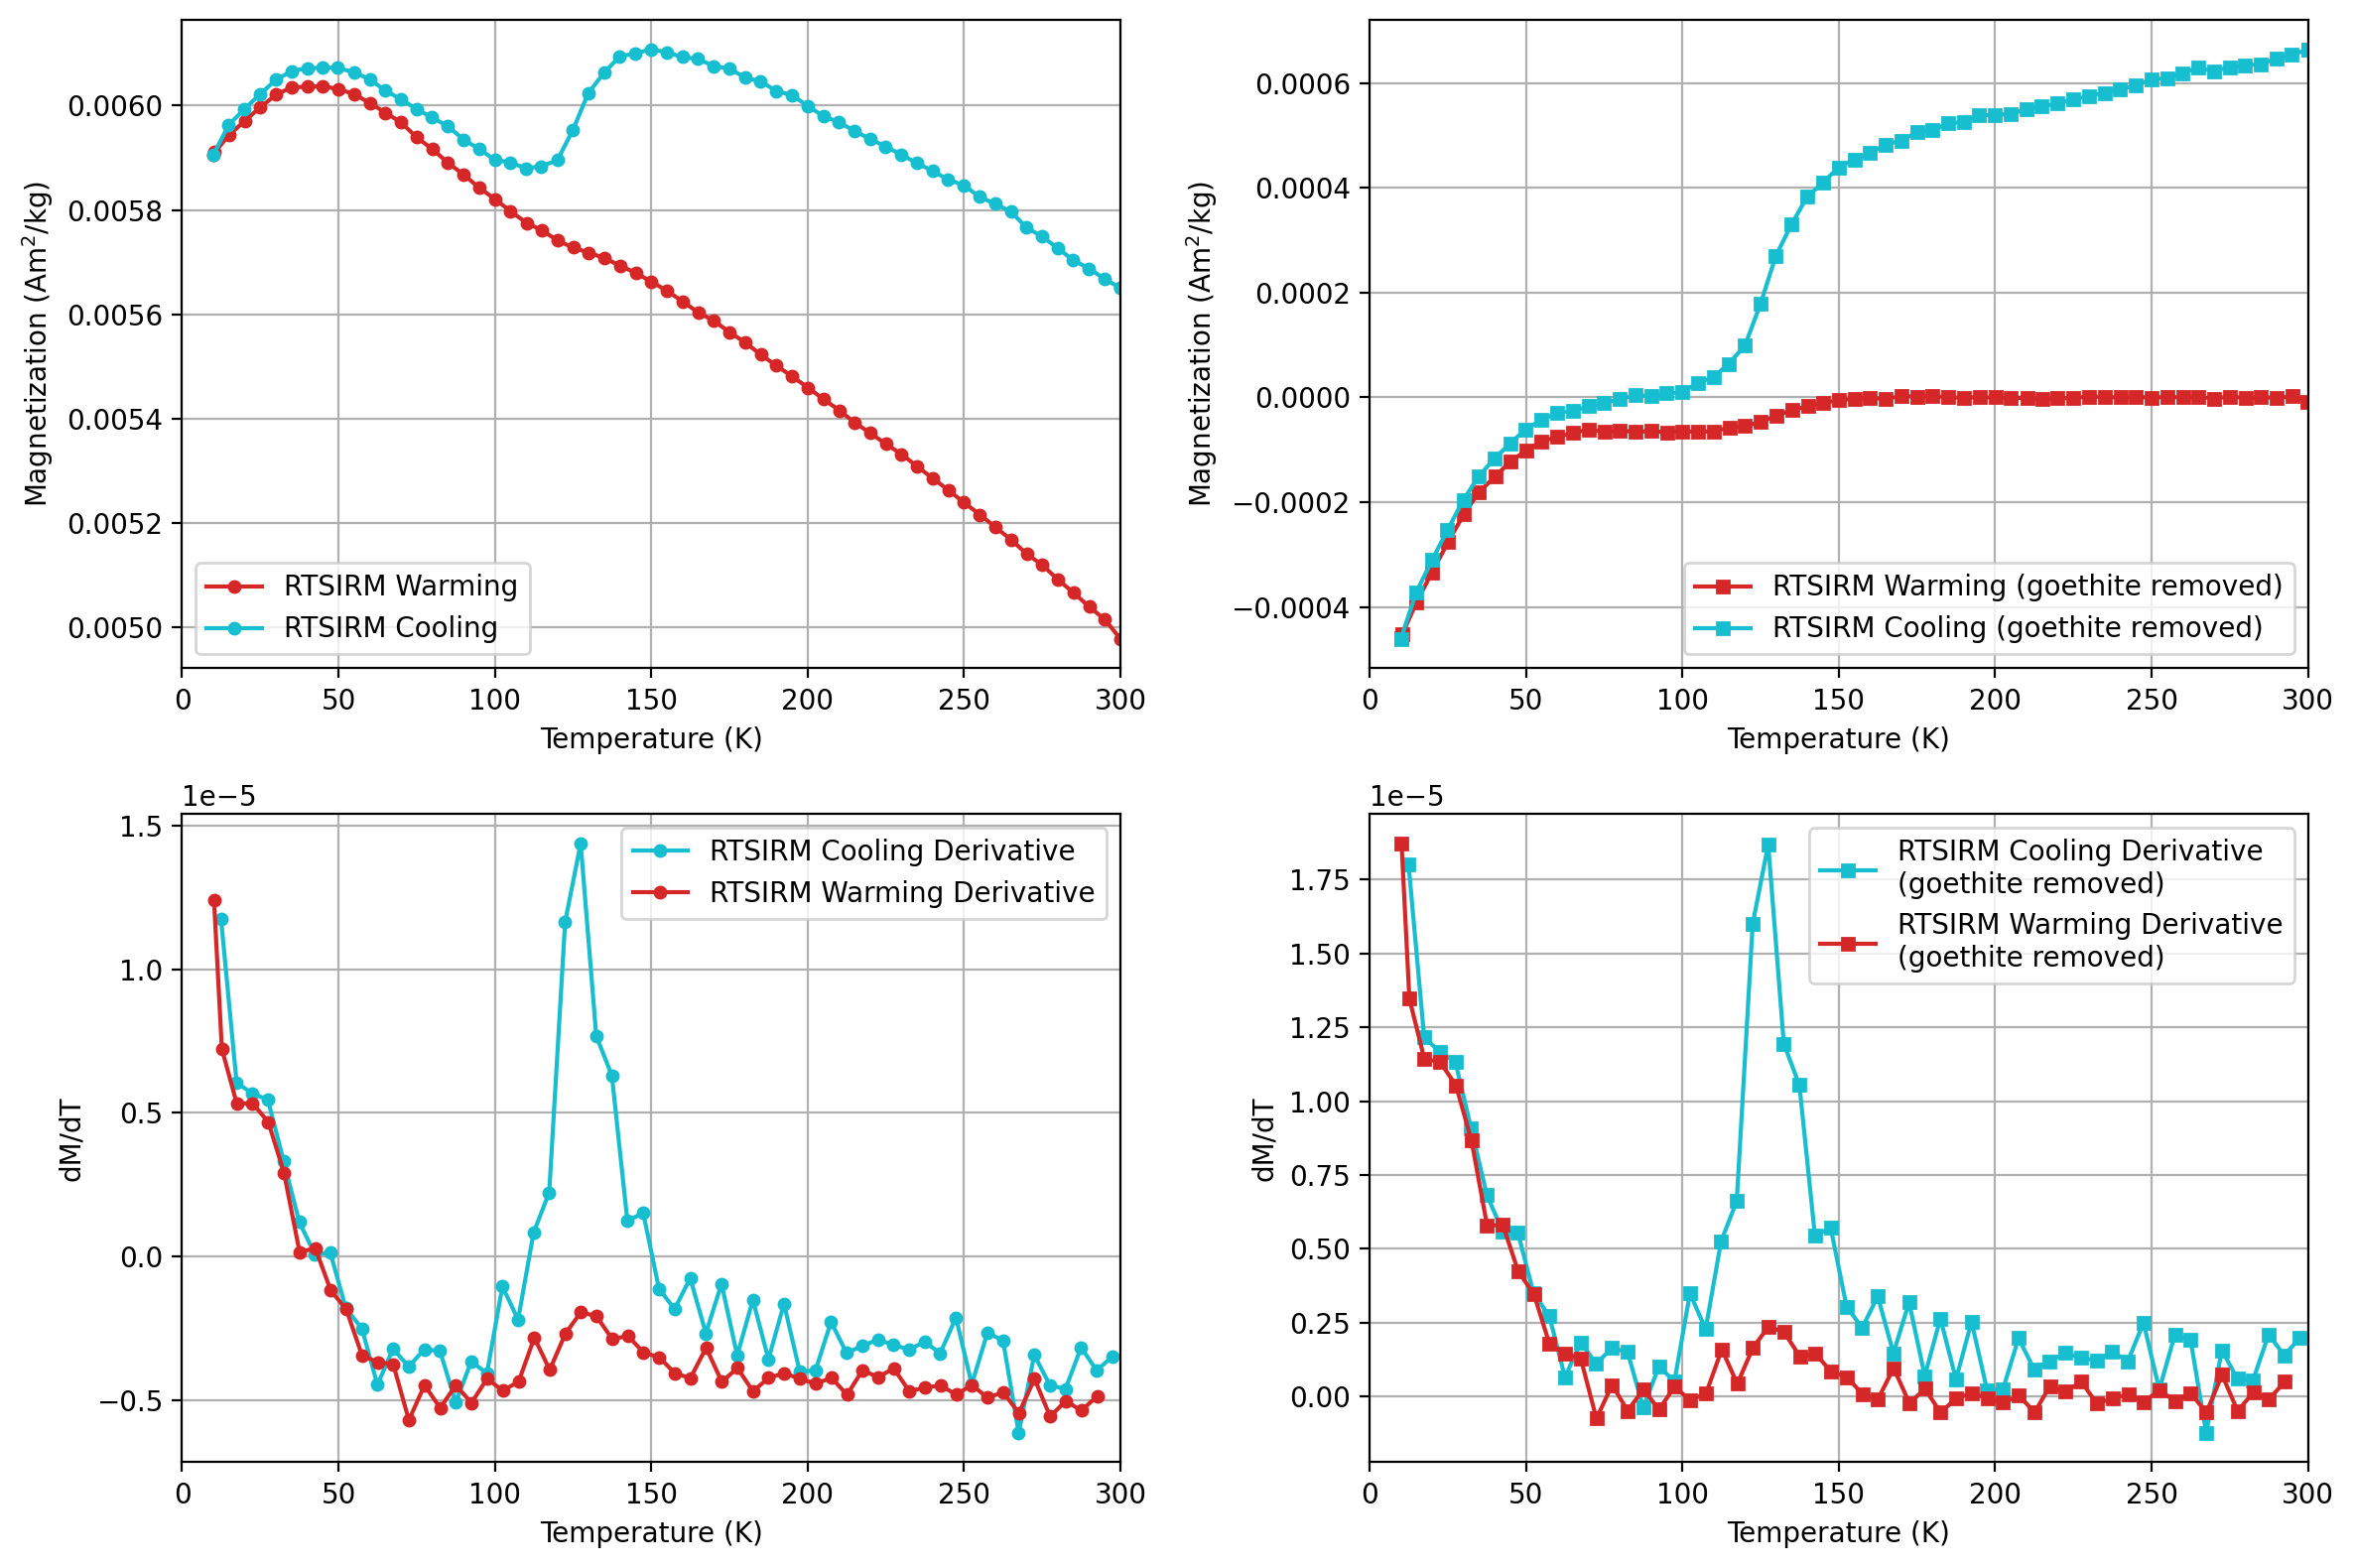

In [13]:
goethite_removal(rtsirm_warm_data, 
                     rtsirm_cool_data,
                     t_min=160, t_max=295, poly_deg=3)

## Apply the function and return the values

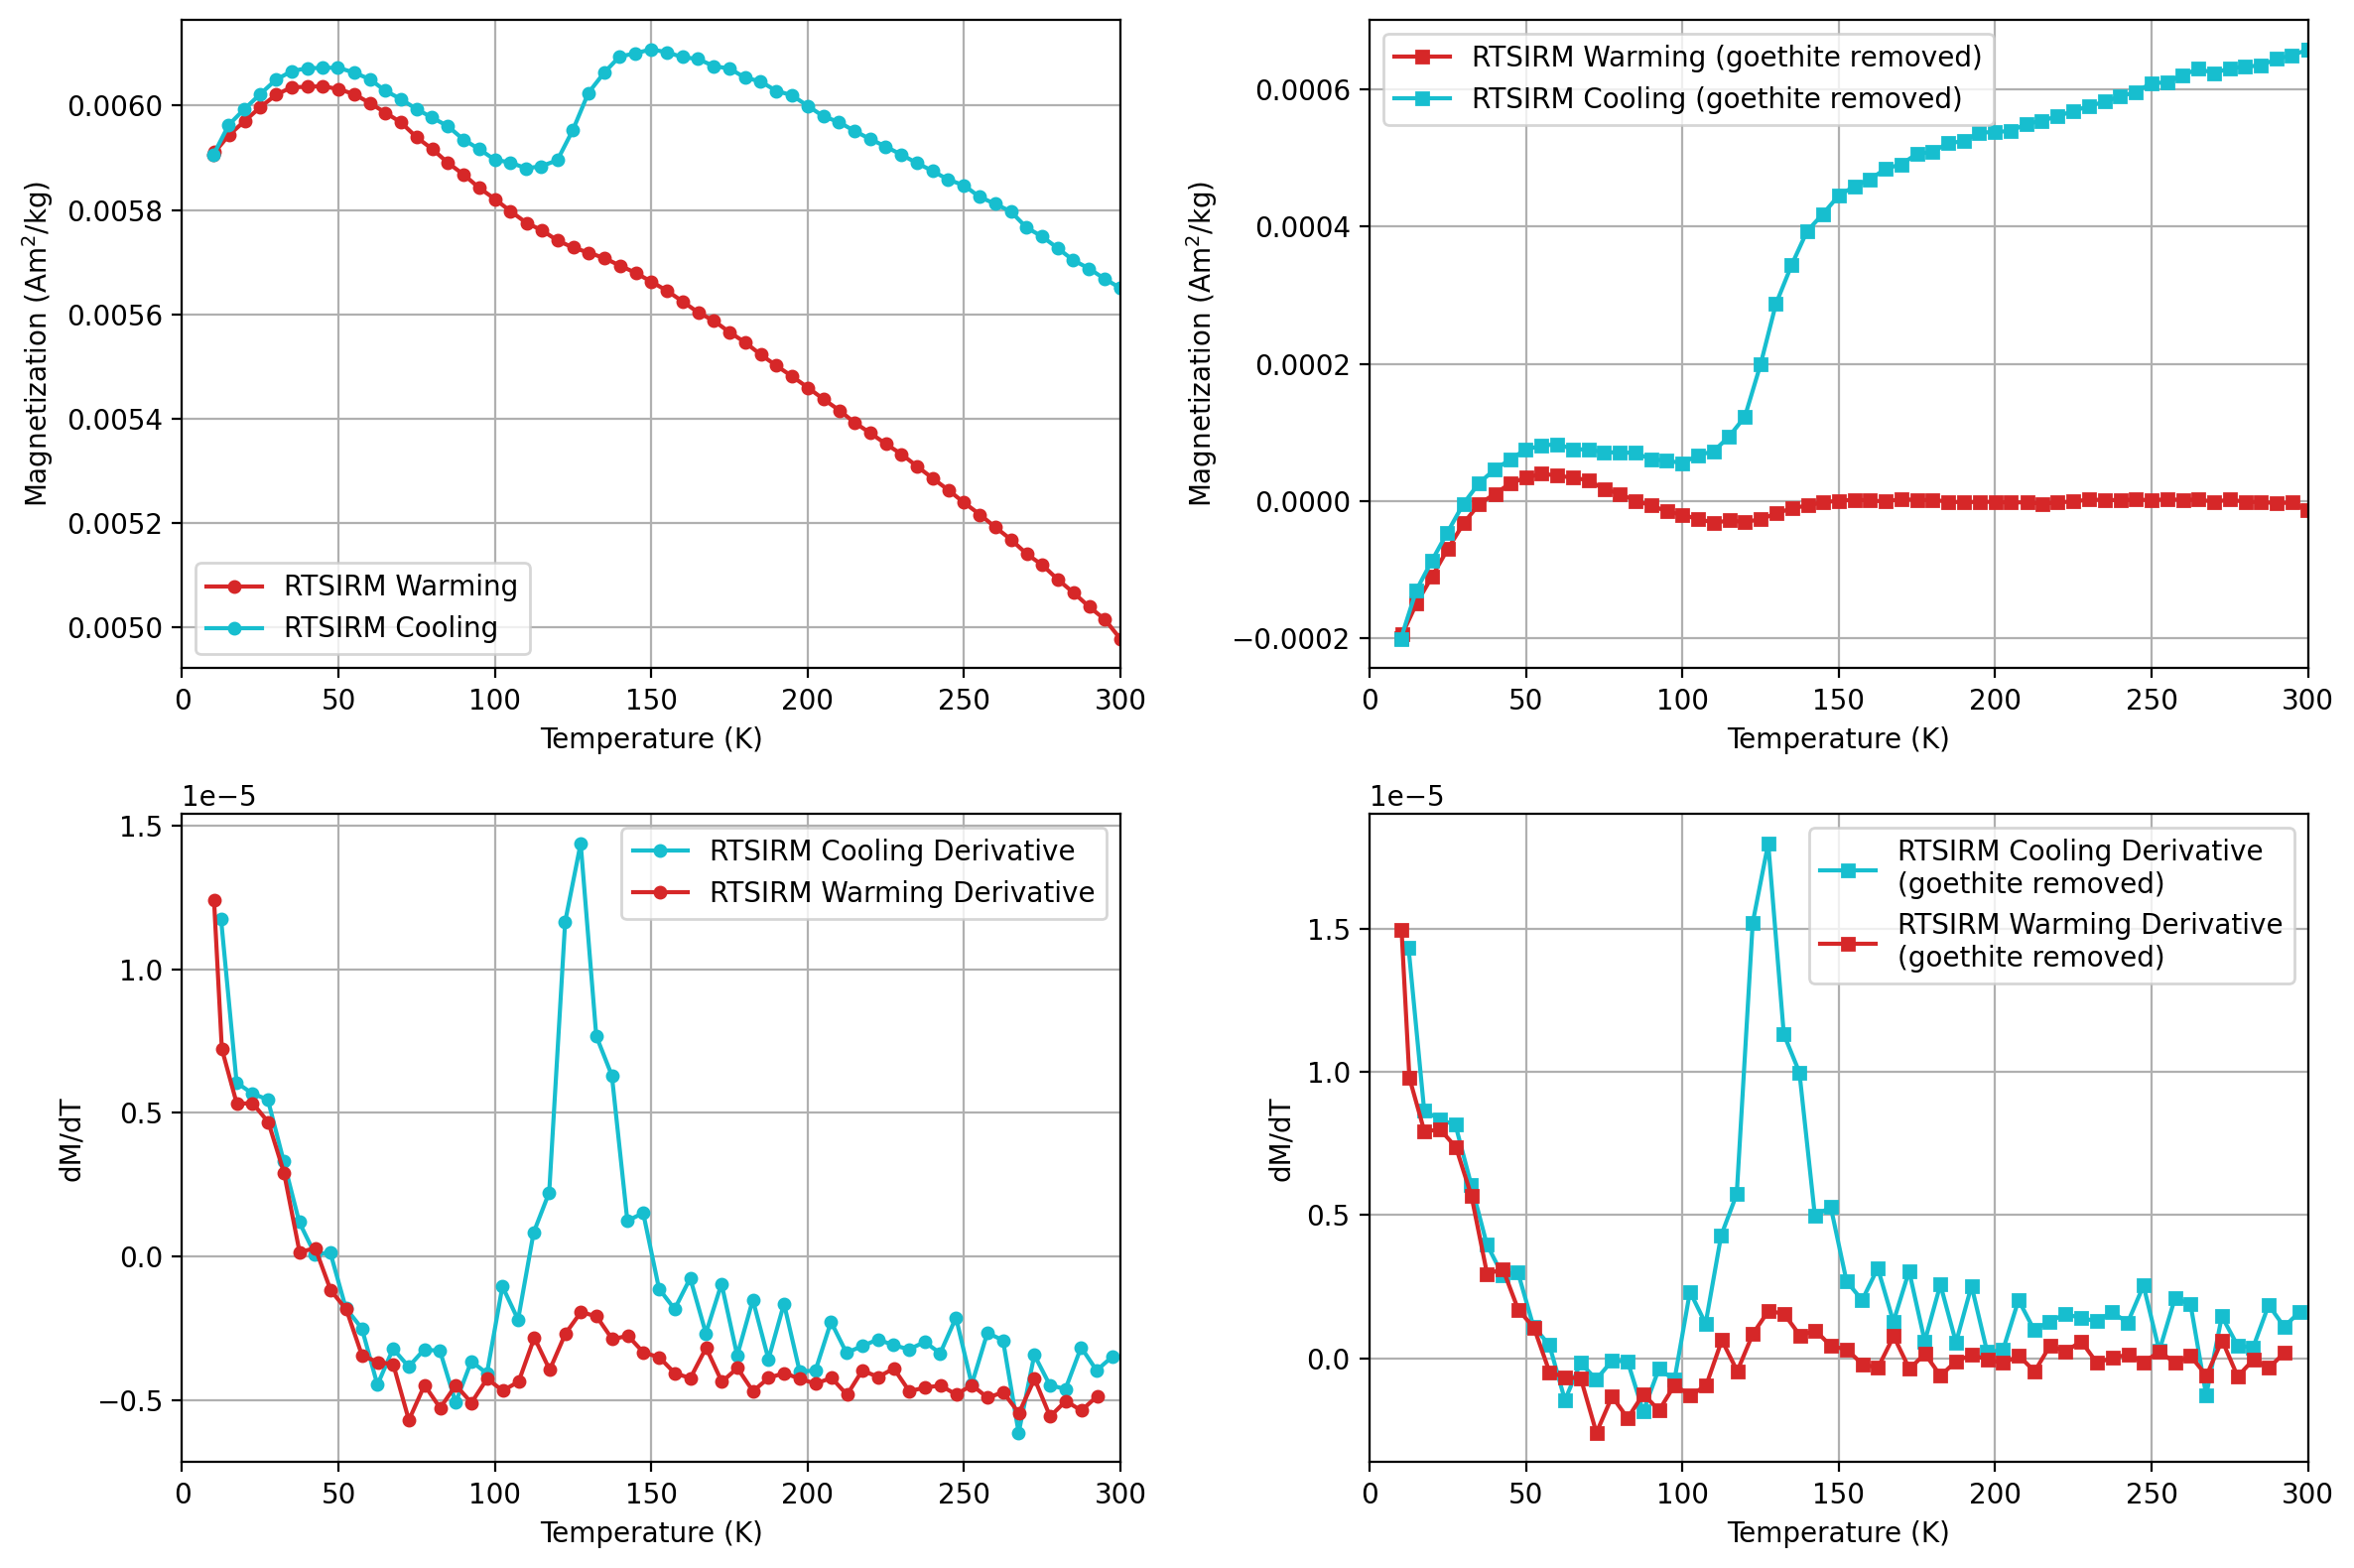

In [17]:
rtsirm_warm_mags_corrected, rtsirm_cool_mags_corrected = goethite_removal(rtsirm_warm_data, 
                     rtsirm_cool_data,
                     t_min=160, t_max=295, poly_deg=2, return_data=True)

In [15]:
rtsirm_warm_mags_corrected

0    -2.005551e-04
1    -1.941609e-04
2    -1.492886e-04
3    -1.097448e-04
4    -6.945037e-05
5    -3.195035e-05
6    -4.444460e-06
7     1.061835e-05
8     2.589195e-05
9     3.429536e-05
10    3.963193e-05
11    3.718514e-05
12    3.383987e-05
13    3.032607e-05
14    1.724594e-05
15    1.054675e-05
16    1.241645e-07
17   -6.179058e-06
18   -1.530205e-05
19   -1.999622e-05
20   -2.654022e-05
21   -3.146025e-05
22   -2.841693e-05
23   -3.068111e-05
24   -2.644951e-05
25   -1.819376e-05
26   -1.049555e-05
27   -6.439402e-06
28   -1.710030e-06
29    4.006654e-07
30    1.928592e-06
31    8.827997e-07
32   -7.872698e-07
33    3.078331e-06
34    1.183847e-06
35    1.927830e-06
36   -1.163796e-06
37   -1.686591e-06
38   -1.129069e-06
39   -1.362210e-06
40   -2.213943e-06
41   -1.798546e-06
42   -4.046677e-06
43   -1.920588e-06
44   -6.961309e-07
45    2.201432e-06
46    1.378179e-06
47    1.437474e-06
48    2.034237e-06
49    1.315978e-06
50    2.483871e-06
51    1.664991e-06
52    2.0252

## References cited

Liu, Q., Yu, Y., Torrent, J., Roberts, A. P., Pan, Y., and Zhu, R., 2006, Characteristic low-temperature magnetic
properties of aluminous goethite [α-(Fe, Al)OOH] explained: Journal of Geophysical Research, v. 111,
B12S34, http://dx.doi.org/10.1029/2006JB004560

Rochette, P., and Fillion, G., 1989, Field and temperature behavior of remanence in synthetic goethite:
Paleomagnetic implications: Geophysical Research Letters, v. 16, n. 8, p. 851–854, http://dx.doi.org/
10.1029/GL016i008p00851